In [4]:
import re
import pandas as pd 
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
from sklearn.neighbors import KNeighborsClassifier

# Get data

In [5]:
dataset_filename = "../../preprocessing/data/processed_merge.csv"
df = pd.read_csv(dataset_filename, encoding='utf8', index_col=False)

In [6]:
df.head()

,Unnamed: 0.1,Unnamed: 0,scenario,source_file,original_text,preprocessed_text,label
0,0,27662,Window,UMD24.cha,"+"" I was just practicing . 714781_715861",i was just practicing.,0
1,1,29731,Umbrella,wright01a.cha,"+"" I'll be okay . 2117418_2117778",i will be okay.,0
2,2,4279,Cinderella,73-2.cha,Cinderella &-um &-um two . 697729_703189,cinderella two.,1
3,3,4963,BNT,adler13a.cha,yes ‡ &=laughs <I know> [/] I know . 1725952_...,yes i know i know.,1
4,4,14394,Cat,17-1.cha,&-um but somehow the fireman came . 606241_61...,but somehow the fireman came.,0


In [7]:
# no null values 
df.isnull().sum()

Unnamed: 0.1         0
Unnamed: 0           0
scenario             0
source_file          0
original_text        0
preprocessed_text    0
label                0
dtype: int64

In [8]:
sentences = df["preprocessed_text"]

<Axes: xlabel='label', ylabel='count'>

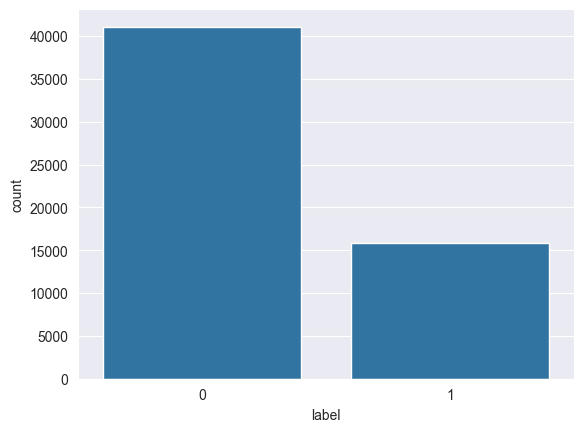

In [9]:
# A bit unbalanced
sns.countplot(x="label",data=df)

<Axes: xlabel='label', ylabel='count'>

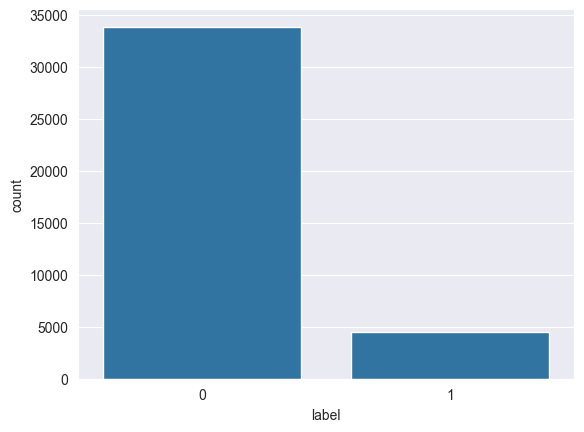

In [10]:
# removing sentences which have less than 5 words, makes dataset more unbalanced
import re
sentences = df["preprocessed_text"]
x = pd.Series([len(re.findall("[a-zA-Z_]+", x)) for x in sentences])
df.insert(loc=0, column="lens", value=x)
df = df[df['lens'] >= 5]
sns.countplot(x="label", data=df)

In [11]:
input_df = df

In [12]:
input_df

,lens,Unnamed: 0.1,Unnamed: 0,scenario,source_file,original_text,preprocessed_text,label
3,5,3,4963,BNT,adler13a.cha,yes ‡ &=laughs <I know> [/] I know . 1725952_...,yes i know i know.,1
4,5,4,14394,Cat,17-1.cha,&-um but somehow the fireman came . 606241_61...,but somehow the fireman came.,0
5,10,5,1662,Cinderella,1030-5.cha,and [/] &-um and &-um he [* s:uk] want &+t hæp...,and and he want her lettuce and her tie and.,1
6,17,6,21805,Window,richardson178.cha,and he was having fun <until one or> [//] unti...,and he was having fun until one or until one t...,0
7,11,7,7539,Speech,kempler04a.cha,it was because <I can't> [//] &-uh <it was> [/...,it was because i cannot it was i was i i.,1
...,...,...,...,...,...,...,...,...
56950,6,56950,37490,Umbrella,wright70a.cha,"+"" I don't need an umbrella . 655566_656686",i do not need an umbrella.,0
56951,5,56951,9812,Flood,scale07a.cha,+< &+y yes no yes no yeah &=points:picture . [...,yes no yes no yeah.,1
56952,7,56952,29502,Important_Event,UNH1051.cha,so ‡ I &-um went to school in Florida . 25995...,so i went to school in florida.,0
56953,6,56953,14784,Important_Event,18-2.cha,we would have our nice lunch . 495175_496325,we would have our nice lunch.,0


# Encoding # 1

In [13]:
import multiprocessing
from gensim.models import Word2Vec

In [14]:
cores = multiprocessing.cpu_count()
cores

16

In [15]:
words_in_sentences=[]
for i in input_df["preprocessed_text"]:
    words_in_sentences.append(re.findall(r"[\w']+|[.,!?;]", i.lower()))
words_in_sentences[20]

['and',
 'cinderella',
 'was',
 'looking',
 'at',
 'some',
 'pretty',
 'dresses',
 'and',
 'trying',
 'to',
 'decide',
 'what',
 'to',
 'wear',
 '.']

In [16]:
input_df.iloc[20]

lens                                                                15
Unnamed: 0.1                                                        35
Unnamed: 0                                                       33296
scenario                                                    Cinderella
source_file                                              wright31a.cha
original_text        and Cinderella was looking at some pretty dres...
preprocessed_text    and cinderella was looking at some pretty dres...
label                                                                0
Name: 35, dtype: object

In [17]:
w2v_model = Word2Vec(min_count=1,
                     window=2,
                     vector_size = 300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-10)

In [18]:
w2v_model.build_vocab(words_in_sentences, progress_per=10000)

In [19]:
w2v_model.train(words_in_sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(3503865, 13415340)

In [20]:
w2v_model.save("../models/word2vec_knn.model")

In [21]:
w2v_model = Word2Vec.load("../models/word2vec_knn.model")

In [22]:
vocab=list(w2v_model.wv.key_to_index.keys())
print(len(vocab))

9001


In [23]:
def avg_w2vec(sentences, labels):
    """
    Average Word2Vec approach for creating a vector for a given sentence from the word embeddings of each words of the sentence.
    """

    transformed=[]
    lab = []
    for sentence, label in zip(sentences,labels):
        count=0
        vector=np.zeros(300)
        for word in sentence.split():
            if word in vocab:
                vector+=w2v_model.wv.get_vector(word)
                count+=1
        if count!=0:
            vector/=count
            transformed.append(vector)
            lab.append(label)
    return np.array(transformed), np.array(lab)

In [24]:
transformed_text, labels1= avg_w2vec(input_df["preprocessed_text"], input_df["label"])

# Model fitting

In [25]:
# train test split
x_train,x_test, y_train, y_test = train_test_split(transformed_text, labels1, stratify=labels1, test_size=0.20, random_state=42)

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
# odd k for preventing ties
grid_params = { 'n_neighbors' : [3, 5, 7, 9, 11],
               'metric' : ['manhattan', 'minkowski', 'cosine']}

In [27]:
knn=KNeighborsClassifier()
clf = GridSearchCV(knn, grid_params, n_jobs=10, verbose=1, return_train_score=True)
clf.fit(x_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=10,
             param_grid={'metric': ['manhattan', 'minkowski', 'cosine'],
                         'n_neighbors': [3, 5, 7, 9, 11]},
             return_train_score=True, verbose=1)

In [28]:
result_df = pd.concat([pd.DataFrame(clf.cv_results_["params"]),
                       pd.DataFrame(clf.cv_results_["mean_test_score"], columns=["mean_test_acc"]),
                       pd.DataFrame(clf.cv_results_["mean_train_score"], columns=["mean_train_acc"]),
                       pd.DataFrame(clf.cv_results_["std_train_score"], columns=["std_train_acc"]),
                       pd.DataFrame(clf.cv_results_["std_test_score"], columns=["std_test_acc"])], axis=1)

In [29]:
result_df.to_csv("../models/knn-reverse-results.csv")

In [30]:
clf.best_params_

{'metric': 'cosine', 'n_neighbors': 9}

In [31]:
clf.cv_results_ 

{'mean_fit_time': array([0.13209872, 0.12964311, 0.04812169, 0.05058856, 0.05239387,
        0.05571375, 0.06200876, 0.04713459, 0.05927553, 0.05579557,
        0.07396193, 0.05617256, 0.05226464, 0.04811969, 0.04354935]),
 'std_fit_time': array([0.00691698, 0.00667494, 0.00211189, 0.00619243, 0.00726877,
        0.00526206, 0.00182514, 0.00021179, 0.00633784, 0.00576797,
        0.04034792, 0.02794945, 0.0100388 , 0.00776526, 0.00671313]),
 'mean_score_time': array([31.90655909, 32.05169439, 31.43184152, 31.45287204, 36.99592948,
         2.75690489,  3.24487476,  3.12550631,  3.17364445,  2.95043569,
        14.79277577,  4.27106905,  4.53332124,  4.08414836,  4.14876547]),
 'std_score_time': array([0.11353427, 0.1362676 , 0.03056649, 0.03910468, 0.07818855,
        0.07522691, 0.04008997, 0.06174089, 0.02949635, 0.02720512,
        3.42539241, 0.0830055 , 0.7064567 , 0.10911911, 0.0984408 ]),
 'param_metric': masked_array(data=['manhattan', 'manhattan', 'manhattan', 'manhattan',
   

In [32]:
knn = KNeighborsClassifier(n_neighbors=clf.best_params_['n_neighbors'], metric=clf.best_params_['metric'])
knn.fit(x_train, y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=9)

In [33]:
knnPickle = open('knn_pickle', 'wb')
pickle.dump(knn, knnPickle)
knnPickle.close()

# Training + testing plots

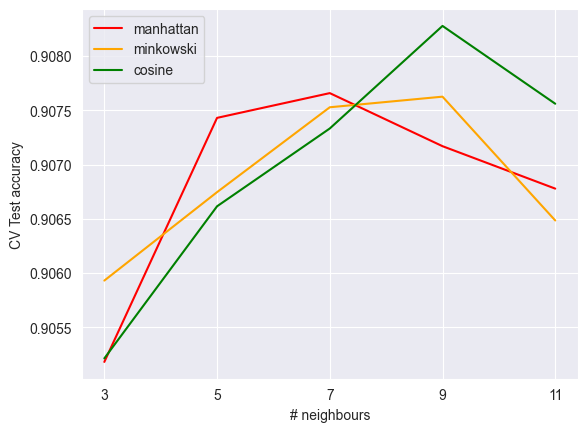

In [35]:
import matplotlib.pyplot as plt

result_df = pd.read_csv("../models/knn-reverse-results.csv", encoding="utf-8")
cols = ['red', 'orange', 'green']
for metric, col in zip(grid_params['metric'], cols):
    plt.plot(result_df[result_df.metric == metric].n_neighbors, result_df[result_df.metric == metric].mean_test_acc, color=col, label=metric)

plt.xlabel("# neighbours")
plt.ylabel("CV Test accuracy")
plt.xticks(grid_params['n_neighbors'])
plt.legend()
plt.show()

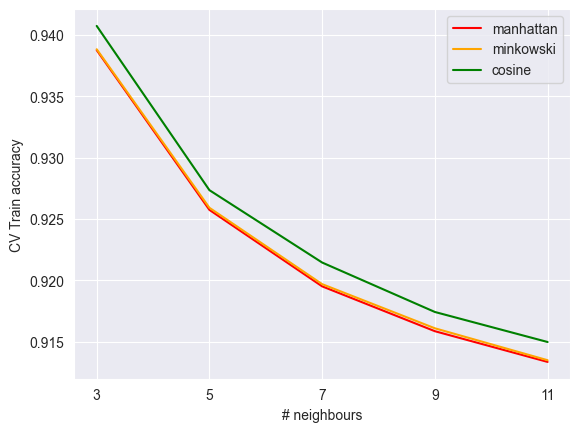

In [36]:
for metric, col in zip(grid_params['metric'], cols):
    plt.plot(result_df[result_df.metric == metric].n_neighbors, result_df[result_df.metric == metric].mean_train_acc, color=col, label=metric)
    # plt.fill_between(result_df[result_df.metric == metric].n_neighbors, result_df[result_df.metric == metric].mean_train_acc - result_df[result_df.metric == metric].std_train_acc,result_df[result_df.metric == metric].mean_train_acc + result_df[result_df.metric == metric].std_train_acc)

plt.xlabel("# neighbours")
plt.ylabel("CV Train accuracy")
plt.xticks(grid_params['n_neighbors'])
plt.legend()
plt.show()

# Evaluation

In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [38]:
loaded_model = pickle.load(open('../models/knn_pickle', 'rb'))

In [39]:
loaded_model

KNeighborsClassifier(metric='cosine', n_neighbors=9)

In [40]:
result = loaded_model.predict(x_test)

In [41]:
len(x_test)

7665

In [42]:
len(y_test)

7665

In [43]:
print(accuracy_score(y_test, result))

0.9068493150684932


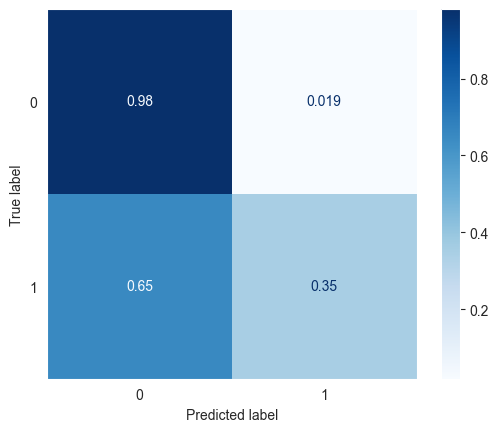

In [44]:
cm = confusion_matrix(y_test, result, normalize='true')
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay.from_estimator(loaded_model, x_test,y_test, normalize="true", cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [45]:
print(tn, fn, tp, fp)

0.9806527839314725 0.6521252796420581 0.3478747203579418 0.019347216068527545


In [46]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = (2 * precision * recall)/ (precision+recall)
print(precision) 
print(recall)
print(f1)

0.9473146504895642
0.3478747203579418
0.508878201979684
